In [73]:
# standard imports
import os
import sys

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import GDAL
from osgeo import gdal

# use GDAL specific exceptions
gdal.UseExceptions()

In [2]:
files = [
    './Vzorka_Asfalt/asfalt_geo.bsq',
    './Vzorka_Kroviny/kroviny_geo.bsq',
    './Vzorka_Polna cesta/polna_cesta_geo.bsq'
]

asfalt_geo.bsq (474, 103, 52)


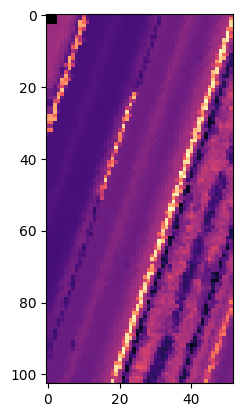

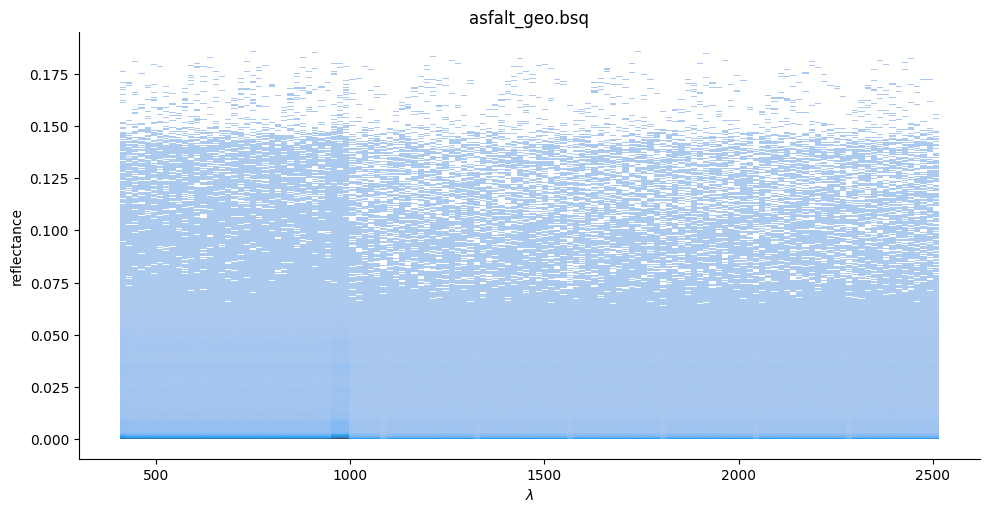

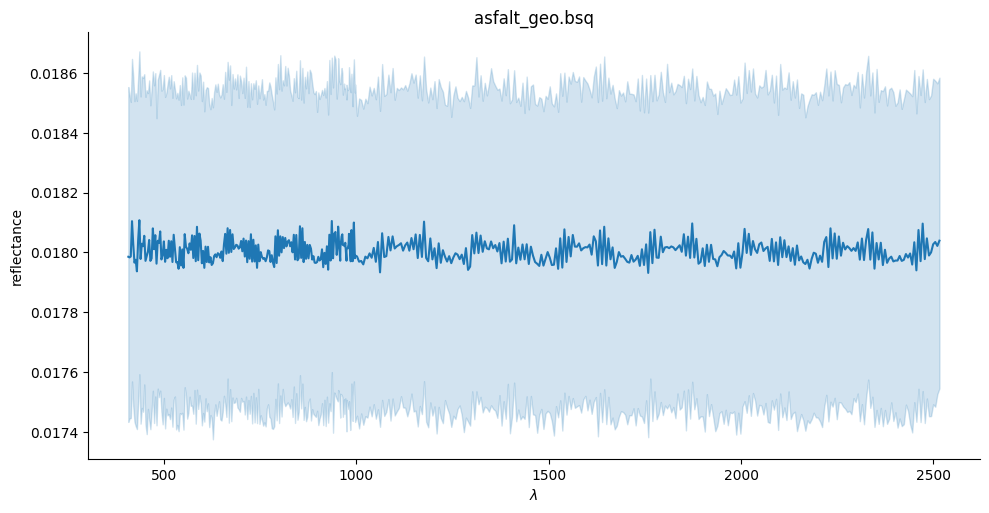

,reflectance,lambda
count,2.538744e+06,2.538744e+06
mean,1.800508e-02,1.329006e+03
std,2.018556e-02,6.248049e+02
min,0.000000e+00,4.067477e+02
25%,1.830155e-03,7.828967e+02
50%,1.010011e-02,1.227493e+03
75%,3.060337e-02,1.873135e+03
max,1.857653e-01,2.516052e+03


kroviny_geo.bsq (474, 131, 66)


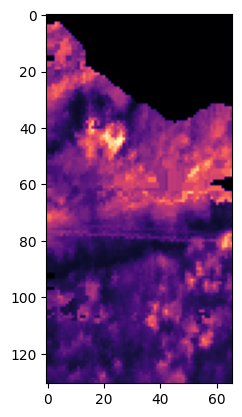

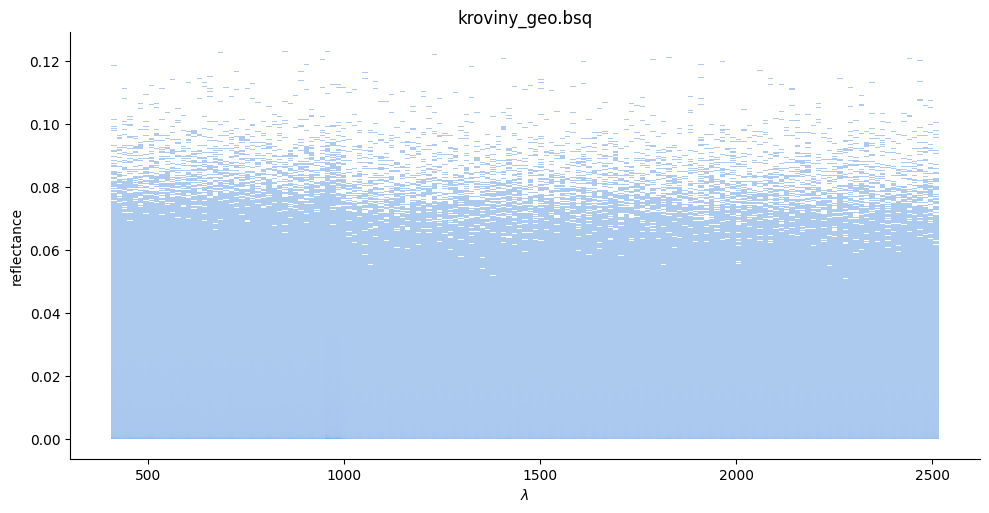

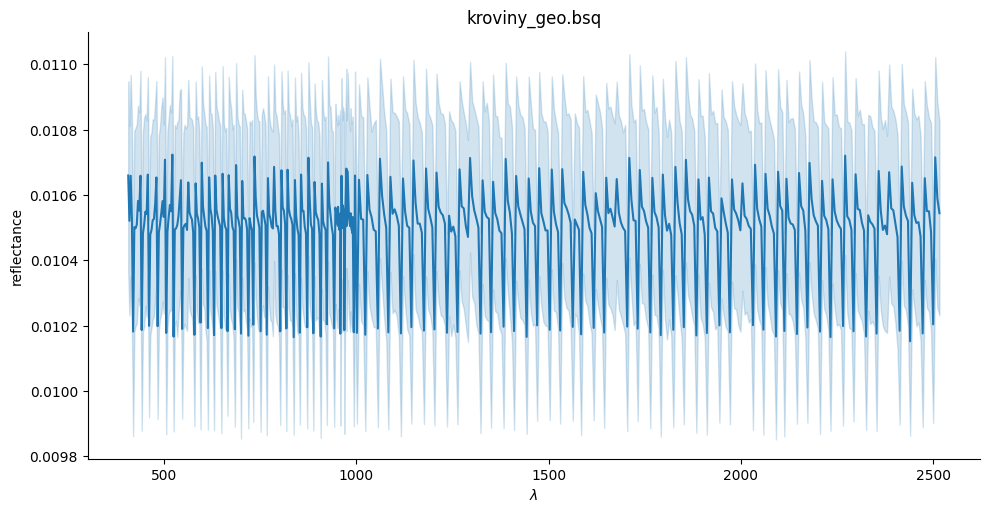

,reflectance,lambda
count,4.098204e+06,4.098204e+06
mean,1.049249e-02,1.329006e+03
std,1.454024e-02,6.248048e+02
min,0.000000e+00,4.067477e+02
25%,2.049668e-04,7.828967e+02
50%,3.882875e-03,1.227493e+03
75%,1.544546e-02,1.873135e+03
max,1.229816e-01,2.516052e+03


polna_cesta_geo.bsq (186, 79, 66)


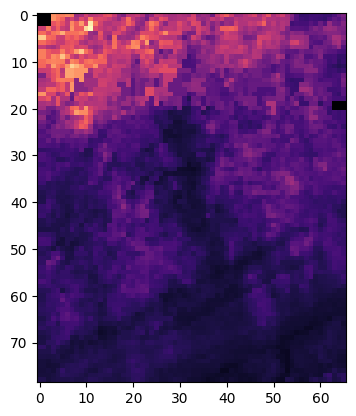

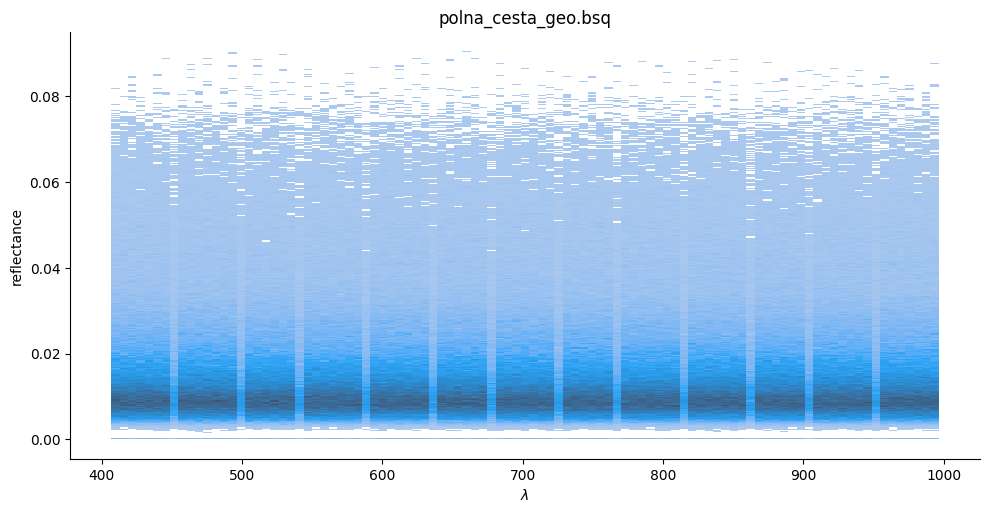

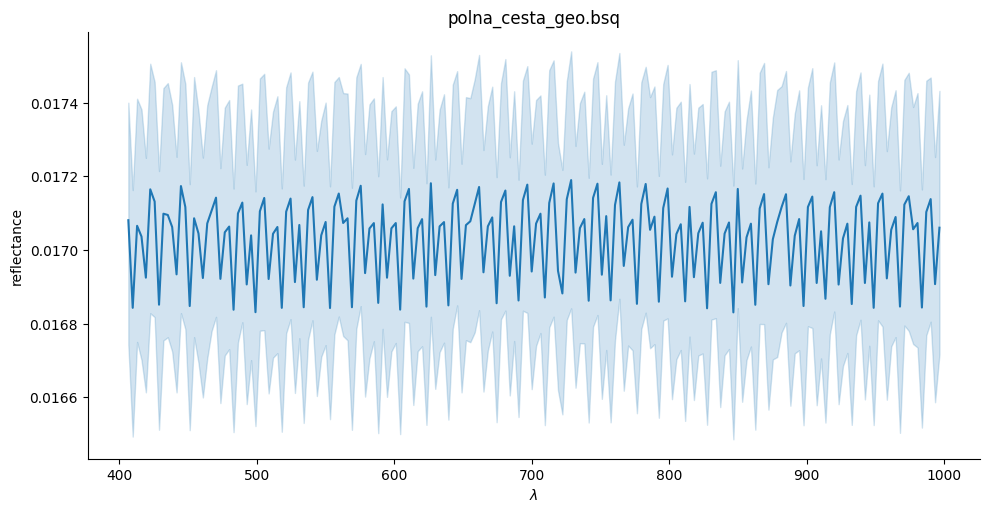

,reflectance,lambda
count,969804.000000,969804.000000
mean,0.017031,701.610352
std,0.012307,171.156815
min,0.000000,406.747681
25%,0.008714,553.382019
50%,0.013025,701.610260
75%,0.021191,849.838440
max,0.090481,996.472839


In [229]:
def plot_wavelengths_v3(df, title=None, filename=None, fileformat='pdf', **args):
    g = sns.relplot(df, x='lambda', y='reflectance', kind='line', **args)
    g.set(xticklabels=[])
    if title is not None:
        g.fig.suptitle(title)
        g.fig.subplots_adjust(top=0.8);
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()

    
    
for file in files:
    
    title = os.path.basename(file)
    
    ds = gdal.Open(file)
    
    a = ds.ReadAsArray()
    print(title, a.shape)
    plt.imshow(a[a.shape[0]//2,:,:], cmap='magma')
    plt.show()
    
    md = ds.GetMetadata()
    df_wavelengths = pd.DataFrame.from_dict(
        {int(re.sub(r'Band_(\d+)', r'\1', k)) : np.float32(v) for k,v in md.items()},
        orient='index',
        columns=['lambda']
    )
    df_wavelengths.index = df_wavelengths.index.sort_values()
    df_wavelengths.index = df_wavelengths.index.rename('band')
    df_wavelengths = df_wavelengths.reset_index()
    
    df = pd.DataFrame(a.reshape(a.shape[2]*a.shape[1], a.shape[0]))
    # df = pd.DataFrame(np.moveaxis(a, [0,1,2], [2,0,1]))
    df = df.melt()
    df = df.rename(columns={'variable': 'band', 'value': 'reflectance'})
    df['band'] = df['band'] + 1
    df = pd.merge(df, df_wavelengths, how='left', left_on='band', right_on='band')
    df = df.drop('band', axis=1)

    ax = sns.displot(df, x='lambda', y='reflectance', aspect=2)
    ax.set(xlabel=r'$\lambda$')
    plt.title(title)
    plt.show()
    
    ax = sns.relplot(df, x='lambda', y='reflectance', kind='line', aspect=2)
    ax.set(xlabel=r'$\lambda$')
    plt.title(title)
    plt.show()
    
    display(df.describe())